In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from Model import FCN
from Dataset import DatasetHandler
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(123)

class PINN():
    "Defines a PINNs. Input (t, x) => Output (T_f, T_s)"
    def __init__(self, N_INTERIOR, N_INITIAL, N_BOUNDARY):
        super().__init__()
        self.n_interior_ = N_INTERIOR # number of interior point
        self.n_initial_ = N_INITIAL
        self.n_boundary_ = N_BOUNDARY

        self.alpha_f = 0.05
        self.alpha_s = 0.08
        self.h_f = 5 # heat transfer fluid
        self.h_s = 6 # heat transfer solid
        self.T_hot = 4
        self.T_0 = 1
        self.u_f = 1 # thermal_conductivity

        # Set extrema for solution domain of t and x
        self.domain_boundaries = torch.tensor([[0.0,1.0], [0.0,1.0]])

        # Set number of space dimensions
        #self.space_dim = 1

        self.model = FCN(IN_DIM=self.domain_boundaries.shape[0], OUT_DIM=2,
                                            N_HIDDEN_LAYERS=4, N_NEURONS=20, REGULARIZE_PARAM=0.,
                                            REGULARIZE_EXP=2.) # step 1

        # Sobol sequence generator for input sampling
        self.sobol_gen = torch.quasirandom.SobolEngine(dimension=self.domain_boundaries.shape[0])
        self.dataset_handler = DatasetHandler(self.sobol_gen, self.domain_boundaries)
        self.training_sets = self.dataset_handler.create_datasets(self.n_interior_, self.n_boundary_, self.n_initial_)
        # [interior_points, boundary_loader, initial_loader]
        # note: only input_batch, because output_batch is not defined for PDE problems

    #def predict_initial_points(self, input_data):
    #    # input_data = initial points in Data Loader
    #    return self.model(input_data)

    #def predict_boundary_points(self, input_data):
    #    # input_data = initial points in Data Loader
    #    return self.model(input_data)
    def compute_initial_residual(self, initial_points):
        # initial_points (tensor): 2D tensor of boundary points [n_points, 2]
        # in intial_points [x,0]
        initial_points.requires_grad=True
        predictions_t0 = self.model(initial_points)
        T_f_t0 = predictions_t0[:,0]
        T_s_t0 = predictions_t0[:,1]

        T_f_t0_residual = T_f_t0 - self.T_0
        T_s_t0_residual = T_s_t0 - self.T_0

        initial_residual = T_f_t0_residual + T_s_t0_residual
        return initial_residual

    def compute_boundary_residual(self, boundary_points):
        # boundary_points (tensor): 2D tensor of boundary points [n_points, 2]
        # boundary (2)
        boundary_points.requires_grad=True
        mask_x0 = boundary_points[:, 0] == self.domain_boundaries[1, 0]
        mask_xL = boundary_points[:, 0] == self.domain_boundaries[1, 1]

        boundary_points_x0 = boundary_points[mask_x0]
        boundary_points_xL = boundary_points[mask_xL]
        x0_boundary = boundary_points_x0[:,0]
        xL_boundary = boundary_points_xL[:,0]
        t_boundary_x0 = boundary_points_x0[:, 1]
        t = boundary_points[:,1] # tensor of time values

        # done testing
        predictions_x0 = self.model(boundary_points_x0)
        predictions_xL = self.model(boundary_points_xL)

        T_f_x0, T_s_x0 = predictions_x0[:, 0], predictions_x0[:, 1]
        T_f_xL, T_s_xL = predictions_xL[:, 0], predictions_xL[:, 1]

        # Boundary conditions 2 T_f (x=0,t) = T_boundary
        T_boundary = (self.T_hot - self.T_0) / (1 + torch.exp(-200*(t_boundary_x0-0.25))) + self.T_0

        boundary_2_residual = T_f_x0 - T_boundary # T_boundary based on x0

        # Boundary conditions 1

        # turn on requires_grad
        #xL_boundary.requires_grad = True
        #x0_boundary.requires_grad = True
        #grad_fluid_xL = torch.autograd.grad(T_f_xL.sum(), boundary_points_xL, grad_outputs=torch.ones_like(T_f_xL), create_graph=True)[0]

        d_Tf_xL = torch.autograd.grad(T_f_xL.sum(), boundary_points_xL, create_graph=True)[0][:,0]
        d_Tf_x0 = torch.autograd.grad(T_f_x0.sum(), boundary_points_x0, create_graph=True)[0][:,0]
        d_Ts_xL = torch.autograd.grad(T_s_xL.sum(), boundary_points_xL, create_graph=True)[0][:,0] # get dx column, not dt

        boundary_1_residual = d_Tf_xL + d_Tf_x0 + d_Ts_xL

        return boundary_1_residual.reshape(-1,1), boundary_2_residual.reshape(-1,1)

    def compute_pde_residual(self, interior_points):
        interior_points.requires_grad = True
        predictions = self.model(interior_points)

        T_f = predictions[:, 0]
        T_s = predictions[:, 1]

        d_Tf = torch.autograd.grad(T_f.sum(), interior_points, create_graph=True)[0]
        d_Ts = torch.autograd.grad(T_s.sum(), interior_points, create_graph=True)[0]

        dTf_dx = d_Tf[:, 0]
        dTf_dt = d_Tf[:, 1]
        dTs_dx = d_Ts[:, 0]
        dTs_dt = d_Ts[:, 1]

        d2Tf = torch.autograd.grad(d_Tf.sum(), interior_points, create_graph=True)[0]
        d2Ts = torch.autograd.grad(d_Ts.sum(), interior_points, create_graph=True)[0]

        d2Ts_dx2 = d2Ts[:,0]
        d2Tf_dx2 = d2Tf[:,0]

        #grad_fluid_space_2 = torch.autograd.grad(grad_fluid_space.sum(), input_data, create_graph=True)[0][:, 1]
        #grad_solid_space_2 = torch.autograd.grad(grad_solid_space.sum(), input_data, create_graph=True)[0][:, 1]

        residual_fluid = (dTf_dt) + (self.u_f * dTf_dx) - (self.alpha_f * d2Tf_dx2) + (self.h_f * (T_f - T_s))
        residual_solid = (dTs_dt) - (self.alpha_s * d2Ts_dx2) - (self.h_s * (T_f - T_s))

        return residual_fluid.reshape(-1,), residual_solid.reshape(-1,)

    def compute_loss(self, interior_data, boundary_data, initial_data):
        # data in 2D tensor
        boundary_residual_1, boundary_residual_2 = self.compute_boundary_residual(boundary_data)
        boundary_residual = boundary_residual_1 + boundary_residual_2
        initial_residual = self.compute_initial_residual(initial_data)
        #temporal_preds = self.apply_initial_conditions(initial_data)
        #intial_residual = self.compute_boundary_residual
        pde_residuals = self.compute_pde_residual(interior_data)

        #abs(): argument 'input' (position 1) must be Tensor, not tuple
        boundary_loss = torch.mean(torch.abs(boundary_residual) ** 2)

        initial_loss = torch.mean(torch.abs(initial_residual) ** 2)
        #temporal_loss = torch.mean(torch.abs(temporal_data[1] - temporal_preds) ** 2)
        pde_loss = torch.mean(torch.abs(pde_residuals[0]) ** 2) + torch.mean(torch.abs(pde_residuals[1]) ** 2)

        total_loss = boundary_loss + initial_loss + pde_loss
        print("Total loss: ", round(total_loss.item(), 4), "| PDE Loss: ", round(pde_loss.item(), 4), "| Conditions Loss: ", round(boundary_loss.item() + initial_loss.item(), 4))
        return total_loss

    def fit(self, epochs, optimizer):
        history = []

        for epoch in range(epochs):
            # self.training_sets = [interior_loader, boundary_loader, initial_loader]
            for batch in zip(*self.training_sets):
                [interior_points_, boundary_points_, initial_points_] = batch
                #print(boundary_points_)
                def closure():
                    optimizer.zero_grad()

                    loss = self.compute_loss(interior_points_[0], boundary_points_[0], initial_points_[0]) # batch = [2D interioir, 2D boundary, 2D initial]
                    loss.backward()
                    history.append(loss.item())
                    return loss

                optimizer.step(closure)

        return history

    def visualize_results(self):
        test_points = self.sobol_gen.draw(10000)
        output = self.model(test_points)

        fluid_output = output[:, 0].reshape(-1,)
        solid_output = output[:, 1].reshape(-1,)

        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        axes[0].scatter(test_points[:, 0].detach(), test_points[:, 1].detach(), c=fluid_output.detach(), cmap="coolwarm")
        axes[0].set_title("Fluid Temperature")
        axes[1].scatter(test_points[:, 0].detach(), test_points[:, 1].detach(), c=solid_output.detach(), cmap="coolwarm")
        axes[1].set_title("Solid Temperature")
        plt.show()

Streaming output truncated to the last 5000 lines.
Total loss:  0.0018 | PDE Loss:  0.0013 | Conditions Loss:  0.0005
Total loss:  0.0017 | PDE Loss:  0.0013 | Conditions Loss:  0.0005
Total loss:  0.0017 | PDE Loss:  0.0012 | Conditions Loss:  0.0004
Total loss:  0.0016 | PDE Loss:  0.0012 | Conditions Loss:  0.0004
Total loss:  0.0016 | PDE Loss:  0.0011 | Conditions Loss:  0.0004
Total loss:  0.0016 | PDE Loss:  0.0011 | Conditions Loss:  0.0005
Total loss:  0.0015 | PDE Loss:  0.0011 | Conditions Loss:  0.0004
Total loss:  0.0015 | PDE Loss:  0.0011 | Conditions Loss:  0.0004
Total loss:  0.0015 | PDE Loss:  0.001 | Conditions Loss:  0.0004
Total loss:  0.0014 | PDE Loss:  0.001 | Conditions Loss:  0.0004
Total loss:  0.0014 | PDE Loss:  0.001 | Conditions Loss:  0.0004
Total loss:  0.0014 | PDE Loss:  0.001 | Conditions Loss:  0.0004
Total loss:  0.0013 | PDE Loss:  0.0009 | Conditions Loss:  0.0004
Total loss:  0.0013 | PDE Loss:  0.0009 | Conditions Loss:  0.0004
Total loss:  0.

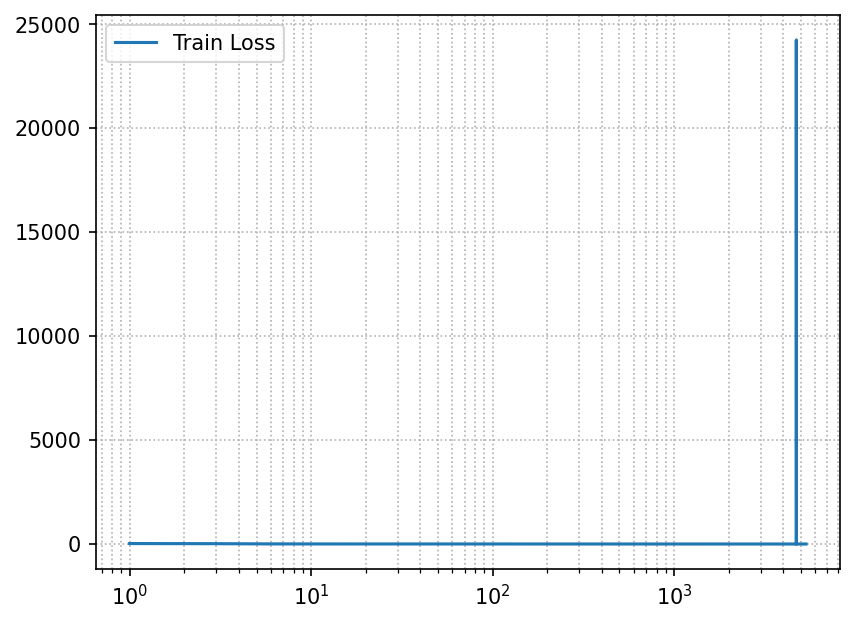

In [ ]:
# Define hyperparameters
n_points = 256
n_boundary = 64
n_initial = 64

solver = PINN(n_points, n_boundary, n_initial)

# Set up optimizer
optimizer_LBFGS = optim.LBFGS(solver.model.parameters(), lr=0.5, max_iter=50000, max_eval=50000, history_size=150, line_search_fn="strong_wolfe")
optimizer_ADAM = optim.Adam(solver.model.parameters(), lr=0.001)

# Train the model
history = solver.fit(epochs=100, optimizer=optimizer_LBFGS)

# Plot training loss history
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(history) + 1), history, label="Train Loss")
plt.xscale("log")
plt.legend()
plt.show()


In [ ]:
# Save the model
torch.save(solver.model.state_dict(), 'hyperparameters.pth')
solver.model.load_state_dict(torch.load("hyperparameters.pth"))

<ipython-input-34-d5ba92c9b6c3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.model.load_state_dict(torch.load("hyperparameters.pth"))


<All keys matched successfully>

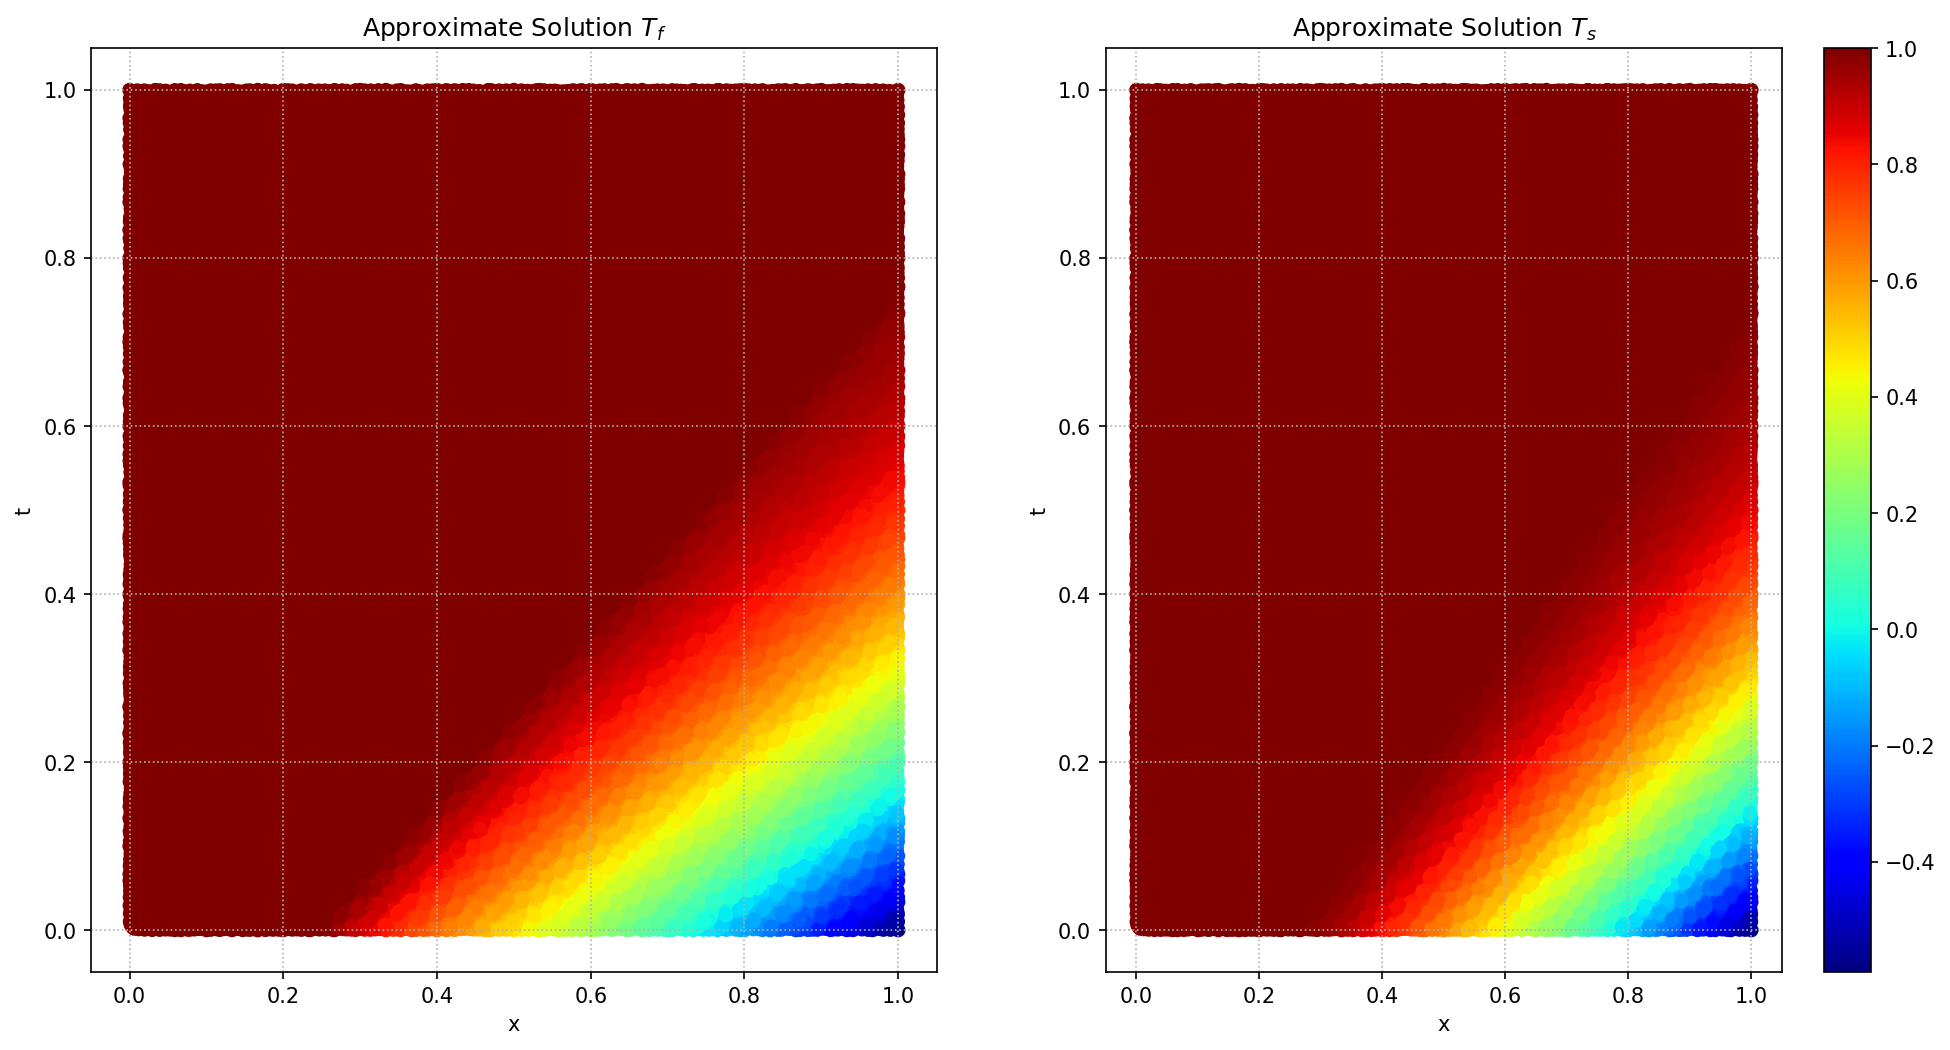

In [ ]:
def plotting(class_object):
    inputs = class_object.sobol_gen.draw(100000)

    output = class_object.model(inputs)
    output_Tf = output[:, 0].reshape(-1, )
    output_Ts = output[:, 1].reshape(-1, )

    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
    im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_Tf.detach(), cmap="jet")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")

    axs[0].grid(True, which="both", ls=":")
    im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_Ts.detach(), cmap="jet")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[0].set_title("Approximate Solution $T_f$")
    axs[1].set_title("Approximate Solution $T_s$")

    plt.show()

plotting(solver)

In [ ]:
test_data = pd.read_csv("TestingData.txt", delimiter=',')
display(test_data)

t_test = torch.tensor(test_data['t'].values, dtype=torch.float32).reshape(-1, 1)
x_test = torch.tensor(test_data['x'].values, dtype=torch.float32).reshape(-1, 1)

test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)

,t,x
0,0.624062,0.895
1,0.783512,0.778
2,0.398106,0.469
3,0.415906,0.948
4,0.949750,0.457
...,...,...
99995,0.811444,0.697
99996,0.498512,0.248
99997,0.718912,0.100
99998,0.953963,0.247


In [ ]:
solution_test_data = solver.model(test_data_tensor)

In [ ]:
save_path_pred = "Quy Le"

test_pred = test_data.copy()
test_pred['tf'] = solution_test_data[:, 0].detach().numpy()
test_pred['ts'] = solution_test_data[:, 1].detach().numpy()
display(test_pred)

test_pred.to_csv("{}/Task1.txt".format(save_path_pred), header=True, index=None, sep=',', mode='w')

,t,x,tf,ts
0,0.624062,0.895,0.964973,0.993541
1,0.783512,0.778,1.000216,1.000158
2,0.398106,0.469,1.000221,1.000227
3,0.415906,0.948,0.636570,0.794006
4,0.949750,0.457,1.000063,0.999975
...,...,...,...,...
99995,0.811444,0.697,1.000194,1.000142
99996,0.498512,0.248,1.000132,1.000106
99997,0.718912,0.100,0.999995,0.999943
99998,0.953963,0.247,0.999968,0.999899


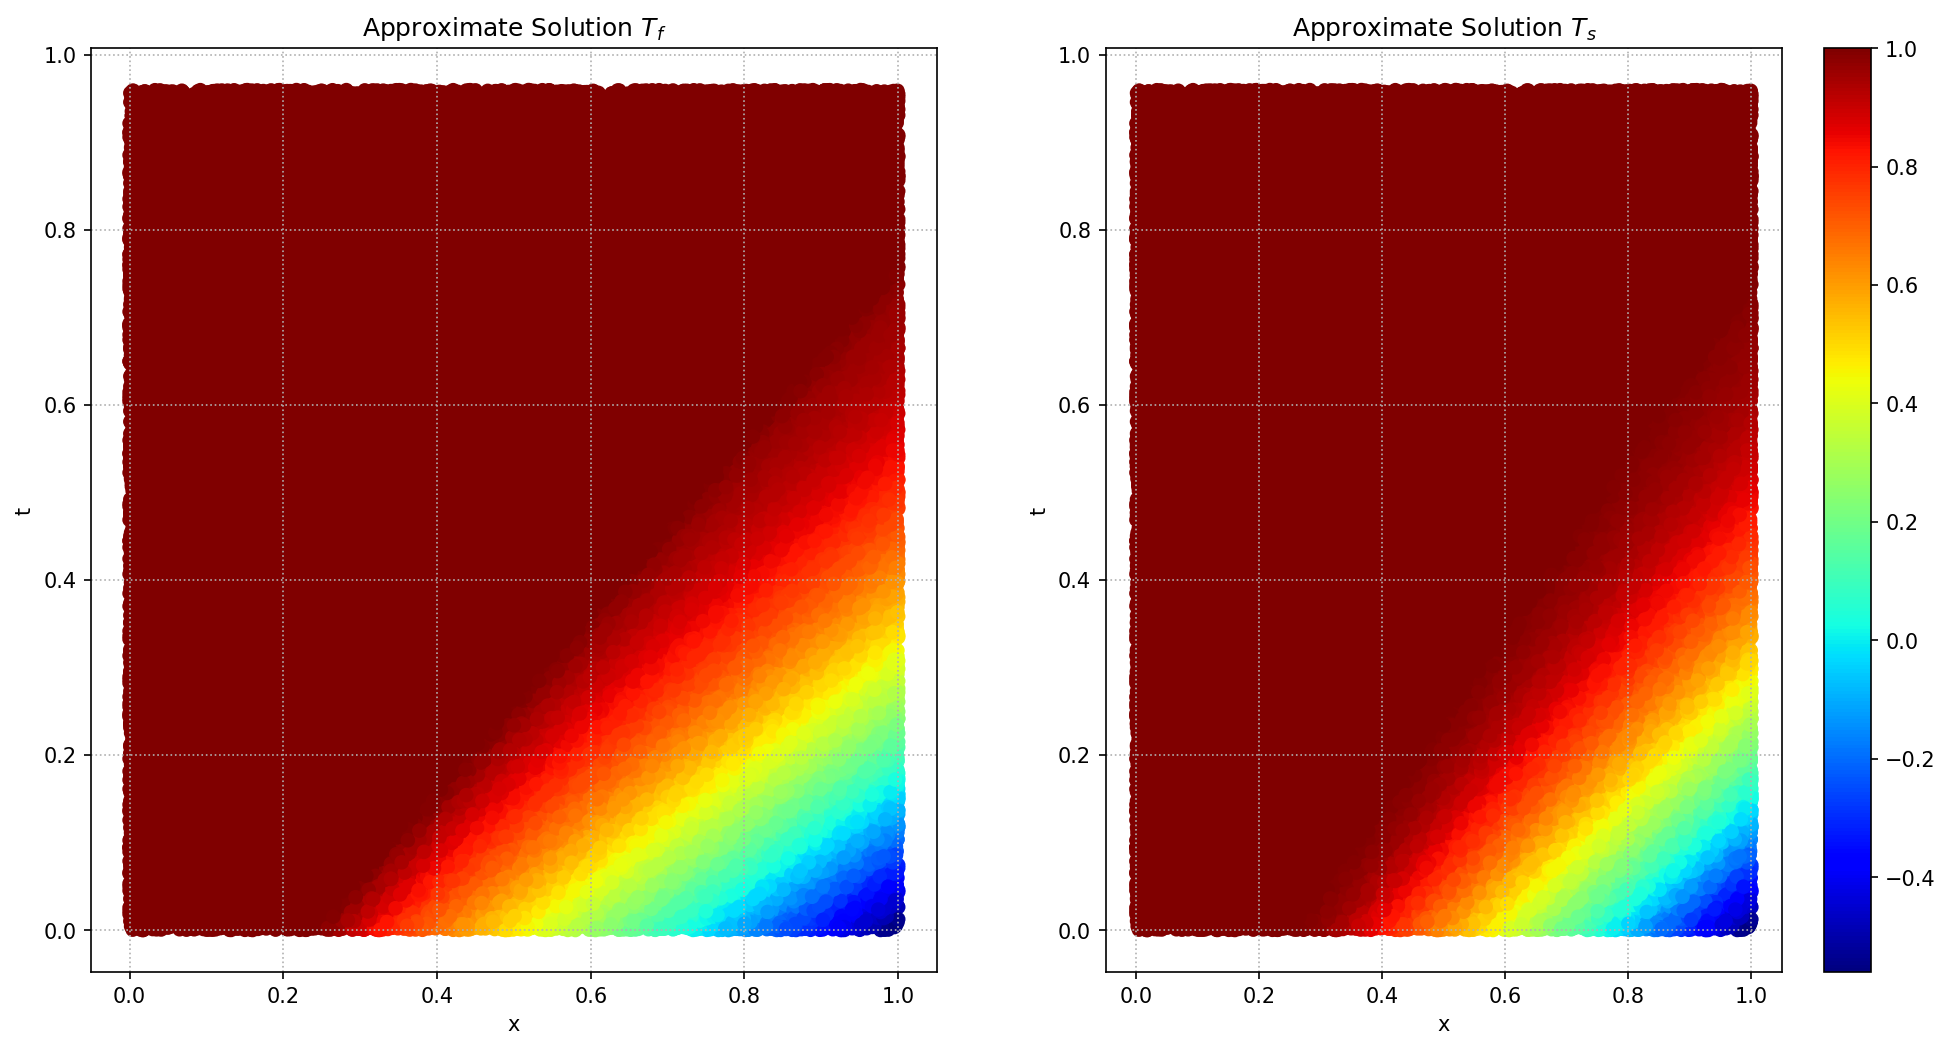

In [ ]:
output = solver.model(test_data_tensor)
output_Tf = output[:, 0].reshape(-1, )
output_Ts = output[:, 1].reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(test_data_tensor[:, 1].detach(), test_data_tensor[:, 0].detach(), c=output_Tf.detach(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(test_data_tensor[:, 1].detach(), test_data_tensor[:, 0].detach(), c=output_Ts.detach(), cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution $T_f$")
axs[1].set_title("Approximate Solution $T_s$")

plt.show()